In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import json
import datetime 
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import requests
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Make results reproducible
def set_seeds(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

def set_global_determinism(seed=0):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(0)

## Model Building

In [4]:
df_final = pd.read_csv('/content/drive/MyDrive/BT4222/hdb data with distances.csv', index_col = 0)

In [5]:
df_final

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,latitude,longitude,nearest mrt,dist to nearest mrt,nearest school,dist to nearest school,nearest mall,dist to nearest mall,dist to cbd,matured
0,2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.333333,...,1.362005,103.853880,Ang Mo Kio MRT Station,1.003997,Townsville Primary School,0.185706,AMK Hub,1.003115,8.237463,1
1,2017-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.083333,...,1.362005,103.853880,Ang Mo Kio MRT Station,1.003997,Townsville Primary School,0.185706,AMK Hub,1.003115,8.237463,1
2,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60.166667,...,1.362005,103.853880,Ang Mo Kio MRT Station,1.003997,Townsville Primary School,0.185706,AMK Hub,1.003115,8.237463,1
3,2018-03-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,60.166667,...,1.362005,103.853880,Ang Mo Kio MRT Station,1.003997,Townsville Primary School,0.185706,AMK Hub,1.003115,8.237463,1
4,2018-05-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,07 TO 09,44.0,Improved,1979,60.083333,...,1.362005,103.853880,Ang Mo Kio MRT Station,1.003997,Townsville Primary School,0.185706,AMK Hub,1.003115,8.237463,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120461,2022-02-01,BUKIT MERAH,4 ROOM,110A,DEPOT RD,01 TO 03,92.0,Model A,2017,94.750000,...,1.281428,103.809243,Telok Blangah MRT Station,1.193602,Blangah Rise Primary School,0.592914,Alexandra Central,0.805653,4.784510,1
120462,2022-02-01,KALLANG/WHAMPOA,3 ROOM,49,JLN BAHAGIA,01 TO 03,80.0,Terrace,1972,49.416667,...,1.327660,103.856373,Boon Keng MRT Station,1.065611,Hong Wen School,0.678932,HDB Hub,0.875751,4.444582,1
120463,2022-02-01,SEMBAWANG,5 ROOM,121A,CANBERRA ST,13 TO 15,113.0,Improved,2018,95.000000,...,1.447602,103.833518,Canberra MRT Station,0.658068,Chongfu School,1.189041,Canberra Plaza,0.587766,17.867919,0
120464,2022-02-01,TAMPINES,3 ROOM,844,TAMPINES ST 82,04 TO 06,64.0,Simplified,1985,62.500000,...,1.352103,103.936534,Tampines MRT Station,0.762443,St. Hilda's Primary School,0.342722,Our Tampines Hub,0.492275,11.817074,1


In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()
df_final['flat_type coded'] = le.fit_transform(df_final['flat_type'])

In [8]:
le.classes_

array(['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION'], dtype=object)

In [9]:
le_storey = LabelEncoder()
df_final['storey_range coded'] = le_storey.fit_transform(df_final['storey_range'])

In [10]:
le_storey.classes_

array(['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15',
       '16 TO 18', '19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30',
       '31 TO 33', '34 TO 36', '37 TO 39', '40 TO 42', '43 TO 45',
       '46 TO 48', '49 TO 51'], dtype=object)

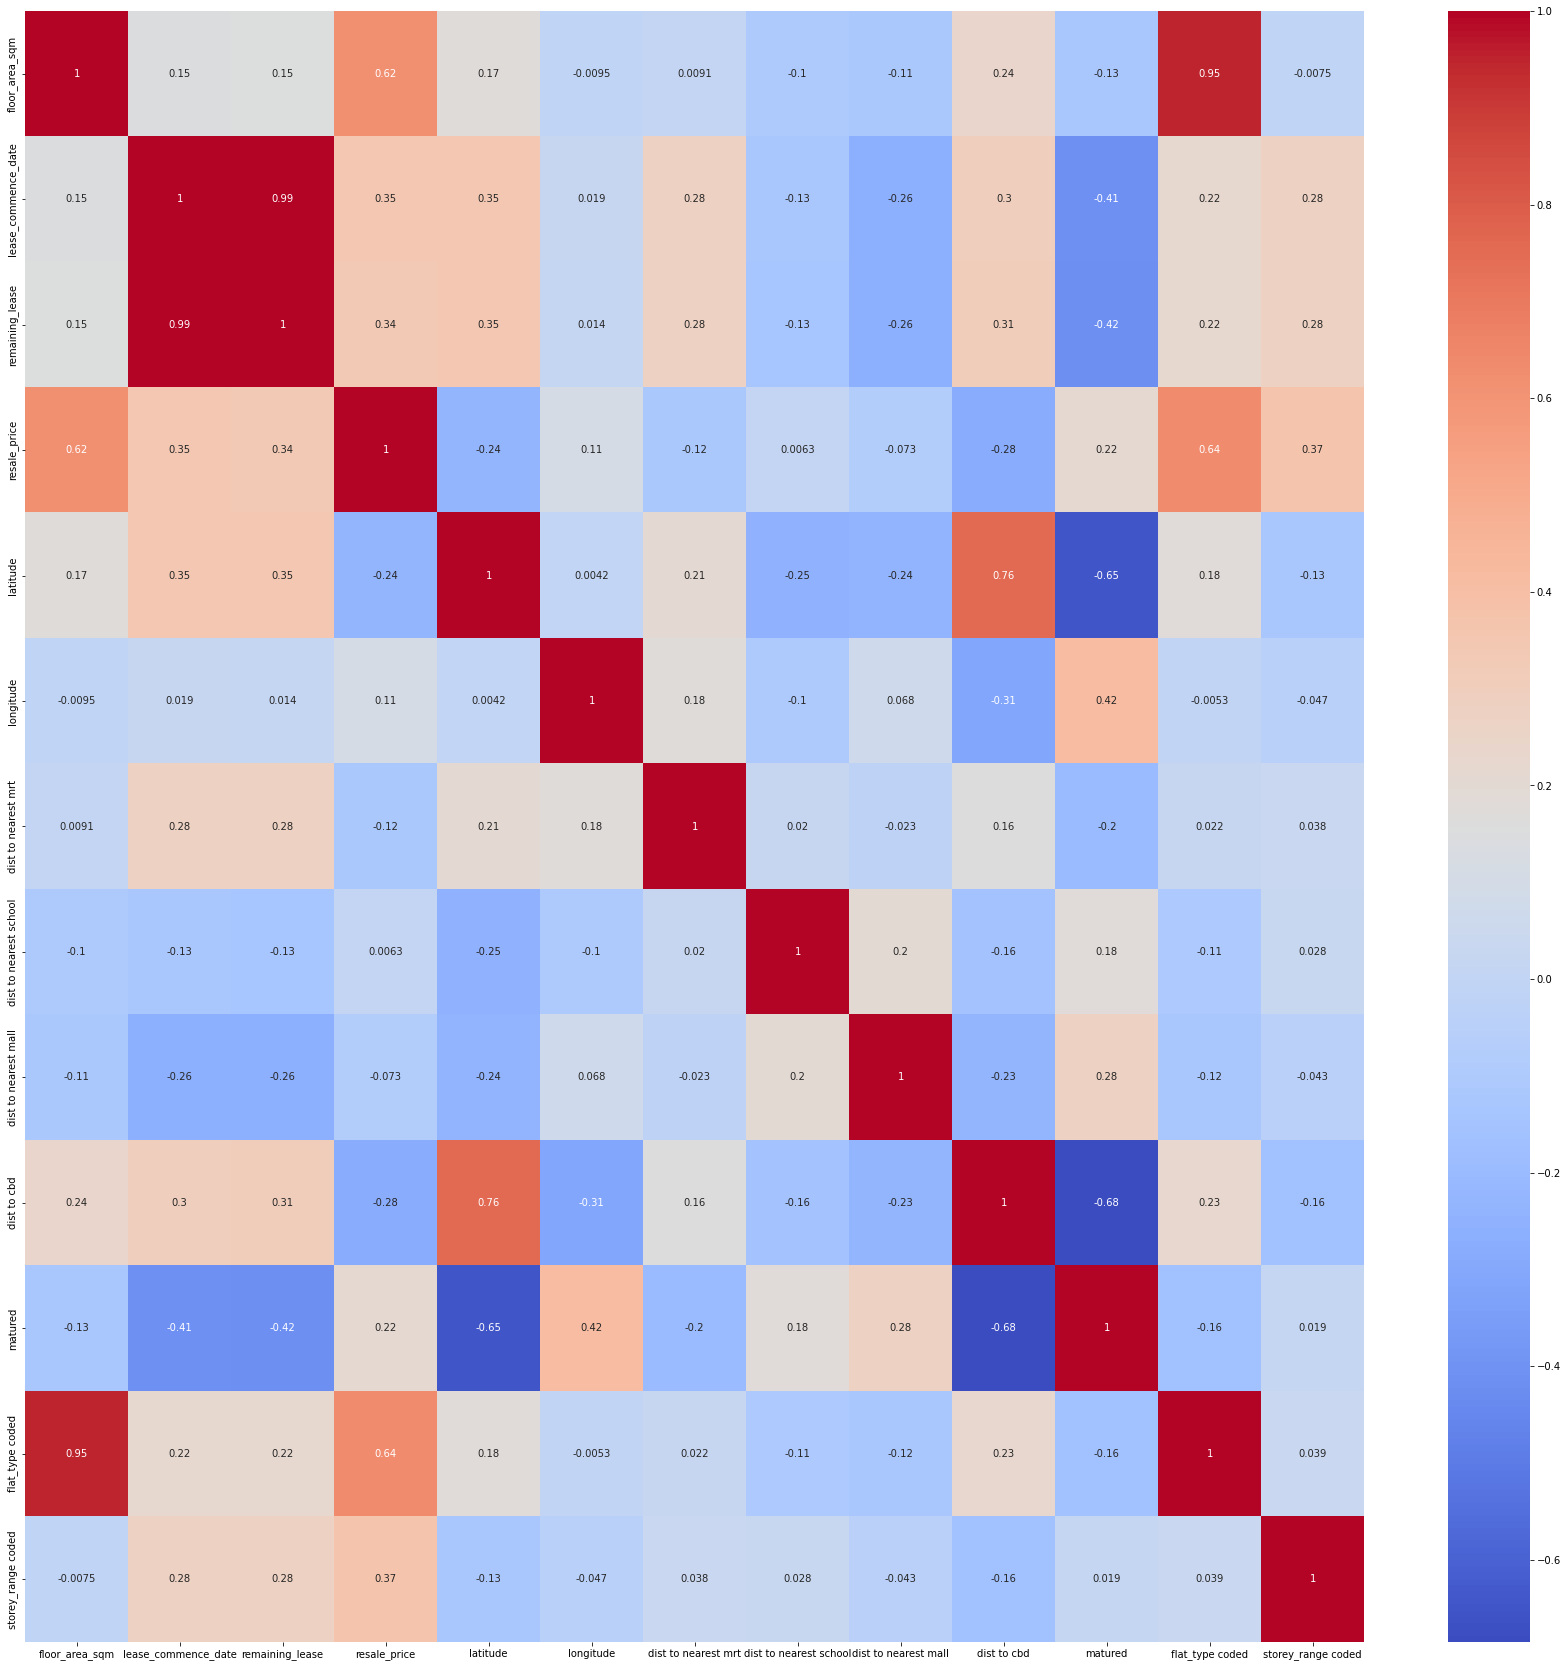

In [11]:
# correlation matrix of the numerical columns
plt.figure(figsize=(30,30))
sns.heatmap(df_final.corr(), annot=True, cmap = 'coolwarm')

From the correlation heatmap, we can see that certain numerical variables are highly correlated with each other. For example, remaining_lease and lease_commencement date has a correlation coefficient of 0.99, which does make sense as the remaining_lease is calculated using 99 - (current year - lease_commencement date). floor_area_sqm has a high correlation coefficient of 0.95 with flat_type coded as well, which is logical because the greater the flat_type, for example 5-room flat, the greater the floor_area_sqm. Hence we choose to drop lease_commencement date and flat_type for the model training

In [12]:
# dummify town and flat_model
df_town = pd.get_dummies(df_final['town'], drop_first = True)
df_model = pd.get_dummies(df_final['flat_model'], drop_first = True)

### Preparing the data. Since we are using past data to predict future resale prices, we cannot use train_test_split to randomly assign train and test data because the dataset follows a chronological order

In [13]:
# 80-20 split for train test
# get only the features we need
X = df_final[['floor_area_sqm', 'remaining_lease', 'dist to nearest mrt', 'dist to nearest school', 'dist to nearest mall', 'dist to cbd', 'matured', 'storey_range coded']]
X = pd.concat([X, df_town, df_model], axis = 1)
y = df_final['resale_price']

train_size = int(len(df_final)*0.8)
X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]

## Using individual baseline models 
### Support Vector Regression, Decision Tree, Linear Regression with Time Series Split

In [15]:
regressors = []
regressors.extend([('SVR', SVR()),
                   ('Decision Tree', DecisionTreeRegressor(random_state = 2022)),
                   ('Linear Regression', LinearRegression())])

In [18]:
X_train

,floor_area_sqm,remaining_lease,dist to nearest mrt,dist to nearest school,dist to nearest mall,dist to cbd,matured,storey_range coded,BEDOK,BISHAN,...,Multi Generation,New Generation,Premium Apartment,Premium Apartment Loft,Premium Maisonette,Simplified,Standard,Terrace,Type S1,Type S2
0,44.0,61.333333,1.003997,0.185706,1.003115,8.237463,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,44.0,61.083333,1.003997,0.185706,1.003115,8.237463,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,44.0,60.166667,1.003997,0.185706,1.003115,8.237463,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44.0,60.166667,1.003997,0.185706,1.003115,8.237463,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44.0,60.083333,1.003997,0.185706,1.003115,8.237463,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24088,147.0,73.166667,1.453837,0.202062,0.283008,15.081952,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
24089,148.0,73.000000,1.453837,0.202062,0.283008,15.081952,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24090,146.0,72.000000,1.453837,0.202062,0.283008,15.081952,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24091,147.0,71.666667,1.453837,0.202062,0.283008,15.081952,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
r2_scores = []
rmse_scores = []
regressor_name = []
for regressor in regressors:
    tscv = TimeSeriesSplit(n_splits=3)
    all_y_preds = []
    all_y_true = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
        y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
        regressor[1].fit(X_train, y_train)
        y_preds = regressor[1].predict(X_test)
        all_y_preds.extend(y_preds)
        all_y_true.extend(y_test)
    r2_scores.append(r2_score(all_y_true,all_y_preds))
    rmse_scores.append(np.sqrt(mean_squared_error(all_y_true, all_y_preds)))
    regressor_name.append(regressor[0])

In [20]:
train_val_results = pd.DataFrame([regressor_name, r2_scores, rmse_scores]).transpose().rename(columns = {0: 'Model', 1: 'R-squared', 2: 'RMSE'}).sort_values(by = 'RMSE', ascending = False)

In [21]:
train_val_results

,Model,R-squared,RMSE
0,SVR,-0.106107,165327.755994
1,Decision Tree,0.810372,68453.916911
2,Linear Regression,0.845993,61690.383497


## Ensemble methods
### Random Forest, Stacking Regressors

In [19]:
base_learners = [('SVR', SVR()),
                 ('Decision Tree', DecisionTreeRegressor(random_state = 2022)),
                 ('Linear Regression', LinearRegression())]

### Linear Regression as meta learner

In [20]:
clf_lr = StackingRegressor(estimators = base_learners, final_estimator = LinearRegression())

### Decision Tree as meta learner

In [21]:
clf_dt = StackingRegressor(estimators = base_learners, final_estimator = DecisionTreeRegressor(random_state = 2022))

### Train the ensemble models

In [22]:
ensembles = []
ensembles.extend([('Linear regression as meta learner', clf_lr),
                  ('Decision Tree as meta learner', clf_dt),
                  ('Random Forest', RandomForestRegressor(random_state = 2022, n_jobs = -1))])

In [23]:
r2_scores_ensemble = []
rmse_scores_ensemble = []
ensemble_name = []
for ensemble in ensembles:
    tscv = TimeSeriesSplit(n_splits=3)
    all_y_preds = []
    all_y_true = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
        y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
        ensemble[1].fit(X_train, y_train)
        y_preds = ensemble[1].predict(X_test)
        all_y_preds.extend(y_preds)
        all_y_true.extend(y_test)
    r2_scores_ensemble.append(r2_score(all_y_true,all_y_preds))
    rmse_scores_ensemble.append(np.sqrt(mean_squared_error(all_y_true, all_y_preds)))
    ensemble_name.append(ensemble[0])

In [24]:
ensemble_results = pd.DataFrame([ensemble_name, r2_scores_ensemble, rmse_scores_ensemble]).transpose().rename(columns = {0: 'Model', 1: 'R-squared', 2: 'RMSE'}).sort_values(by = 'RMSE', ascending = False)

In [25]:
ensemble_results

,Model,R-squared,RMSE
1,Decision Tree as meta learner,0.793683,71402.716636
0,Linear regression as meta learner,0.873331,55947.690612
2,Random Forest,0.878006,54905.654566


## Gradient Boosting models

In [28]:
!pip install xgboost
!pip install lightgbm

In [39]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import lightgbm

In [15]:
boosters = []
boosters.extend([('XGBoost', XGBRegressor()),
                  ('Gradient Boosting', GradientBoostingRegressor()),
                  ('Light Gradient Boosting', LGBMRegressor())])

In [16]:
r2_scores_booster = []
rmse_scores_booster = []
booster_name = []
for booster in boosters:
    tscv = TimeSeriesSplit(n_splits=3)
    all_y_preds = []
    all_y_true = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index[0]:train_index[-1]+1], X[test_index[0]:test_index[-1]+1]
        y_train, y_test = y[train_index[0]:train_index[-1]+1], y[test_index[0]:test_index[-1]+1]
        booster[1].fit(X_train, y_train)
        y_preds = booster[1].predict(X_test)
        all_y_preds.extend(y_preds)
        all_y_true.extend(y_test)
    r2_scores_booster.append(r2_score(all_y_true,all_y_preds))
    rmse_scores_booster.append(np.sqrt(mean_squared_error(all_y_true, all_y_preds)))
    booster_name.append(booster[0])

[05:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:04:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [17]:
booster_results = pd.DataFrame([booster_name, r2_scores_booster, rmse_scores_booster]).transpose().rename(columns = {0: 'Model', 1: 'R-squared', 2: 'RMSE'}).sort_values(by = 'RMSE', ascending = False)

In [18]:
booster_results

,Model,R-squared,RMSE
1,Gradient Boosting,0.857353,59371.647954
0,XGBoost,0.858954,59037.44644
2,Light Gradient Boosting,0.884807,53353.226908


## Hyper parameter tuning of Light Gradient Boosting model

In [27]:
param_search = {'num_leaves':[20,30,40,50,60,70,80,90,100], 'max_depth':[3,4,5,6,7,8,9,10], 'min_data_in_leaf':[4,5,6,7,8,9,10]}
tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=LGBMRegressor(), cv=tscv,
                        param_grid=param_search, scoring ='r2')
gsearch.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_data_in_leaf': [4, 5, 6, 7, 8, 9, 10],
                         'num_leaves': [20, 30, 40, 50, 60, 70, 80, 90, 100]},
             scoring='r2')

In [28]:
gsearch.best_score_


0.8890538636174875

In [29]:
gsearch.best_params_


{'max_depth': 9, 'min_data_in_leaf': 6, 'num_leaves': 80}

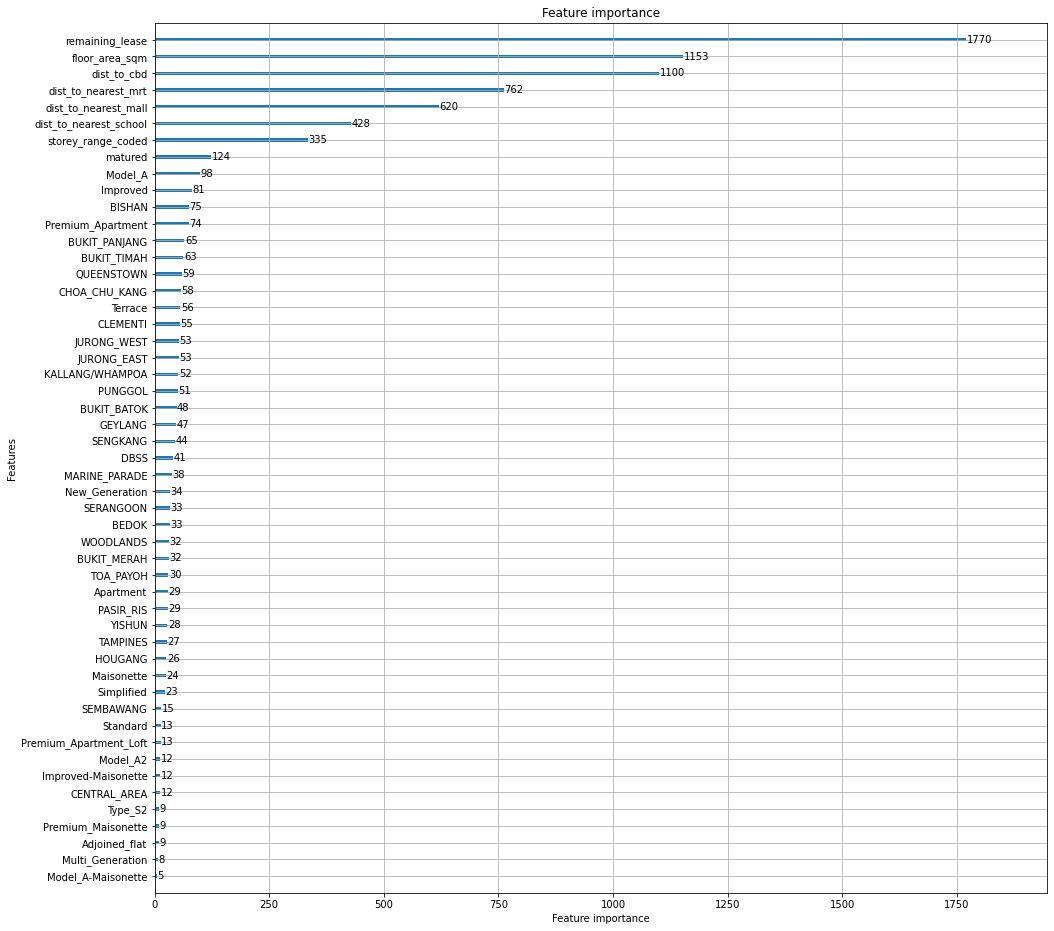

In [40]:
lightgbm.plot_importance(gsearch.best_estimator_, figsize = (16,16))

In [42]:
feature_names = X.columns
feature_values = gsearch.best_estimator_.feature_importances_
feature_importance = pd.DataFrame({'features': feature_names, 'importance': feature_values})


feature_importance.sort_values(by ='importance', ascending = False, inplace = True)

feature_importance[:5]

,features,importance
1,remaining_lease,1770
0,floor_area_sqm,1153
5,dist to cbd,1100
2,dist to nearest mrt,762
4,dist to nearest mall,620
